# Imports


In [1]:
from pathlib import Path

from IPython.core.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg
from infant_connectivity import load_connectivity_data, get_demo_data, label_outliers, \
    plot_outliers, get_ind_both_time_point, logit, add_bin_dist

# Global variables and configuration

In [2]:
palette = sns.color_palette(["green", "orange", "red"])

#con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")
con_path = Path("/Users/christian/Documents/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'

# Loading data

In [3]:
band = "broadband"
dat = pd.read_csv("analysis_data.csv")  # From notebok 2.1

# Distribution raw data only

In [4]:
# resting state networks: default mode network (DMN), dorsal attentional network (DAN), salience network (SAN), auditory network (AUD), visual network (VIS)
# As per: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462789/
dmn_aparc_mapping = {'Default mode': ['isthmuscingulate', 'medialorbitofrontal', 'posteriorcingulate', 
                             'precuneus', 'rostralanteriorcingulate', 'lateralorbitofrontal', 
                             'parahippocampal'],
                     'Dorsal attentional': ['caudalanteriorcingulate', 'inferiortemporal', 'middletemporal',
                             'parsopercularis', 'parsorbitalis', 'parstriangularis'],
                     'Salience': ['insula', 'rostralmiddlefrontal', 'supramarginal', 'caudalmiddlefrontal'],
                     'Auditory': ['superiortemporal'],
                     'Visual': ['cuneus', 'lateraloccipital', 'fusiform', 'lingual']}


In [5]:
region_to_network = dict(zip(np.concatenate(list(dmn_aparc_mapping.values())), 
                             np.concatenate([[network]*len(regions) for network, regions in dmn_aparc_mapping.items()])))

In [6]:
dat["network1"] = dat.region1.str.replace("-rh", "").str.replace("-lh", "").map(region_to_network)
dat["network2"] = dat.region2.str.replace("-rh", "").str.replace("-lh", "").map(region_to_network)
dat["network"] = [n1 if n1 == n2 else np.nan for n1, n2 in zip(dat.network1, dat.network2)]

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_30183/3191191883.py:50: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(h_pad=4, w_pad=1)


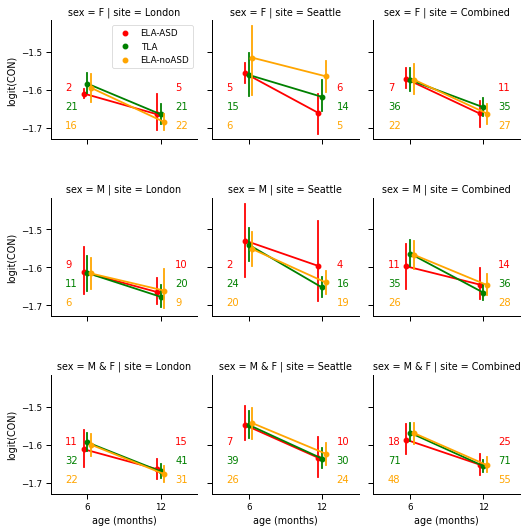

In [7]:
tmp = dat.copy()
tmp["log_con"] = logit(tmp.con)
tmp = tmp[~tmp.outliers_logit]

tmp2 = tmp.copy()
tmp2["site"] = "Combined"
tmp = pd.concat([tmp, tmp2])
tmp2 = tmp.copy()
tmp2["sex"] = "M & F"
tmp = pd.concat([tmp, tmp2])

paper_rc = {'lines.linewidth': 0.5}                  
sns.set_context("paper", rc = paper_rc)  

palette = sns.color_palette(["red", "green", "orange"])

plot_kwds = {"x":"age", "hue":"group",
             "dodge":0.1, "palette":palette, 
             "hue_order":["ELA-ASD", "TLA", "ELA-noASD"],
             "join": True} #, "facet_kws":{"alpha": 0.5}


paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)  

tmp3 = tmp.groupby(["age", "subject", "sex", "site", "group"], observed=True).mean()[["log_con"]].reset_index()

tmp3.group = tmp3.group.astype(str)
tmp3.loc[tmp3.group == "Control", "group"] = "TLA"
tmp3.loc[tmp3.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp3.loc[tmp3.group == "HRA-noASD", "group"] = "ELA-noASD"

col_order = ["London", "Seattle", "Combined"]
row_order = ["F", "M", "M & F"]
g = sns.catplot(data=tmp3, row="sex", col="site", kind="point", y="log_con", 
                col_order=col_order, row_order=row_order, legend_out=False, 
                height=2.5, aspect=1, **plot_kwds)

for ax in g.axes.T[0]:
    ax.set_ylabel("logit(CON)")
    
for ax in g.axes[-1]:
    ax.set_xlabel("age (months)")
for ax in g.axes[0]:
    ax.set_xlabel("")


legend = g.axes[0, 0].legend()

g.fig.tight_layout(h_pad=4, w_pad=1)

group_order = [text.get_text() for text in legend.texts]
color_order = [line.get_color() for line in ax.lines[::3]]

counts = tmp3.groupby(["sex", "site", "group", "age"]).count()["subject"]
for sex, ax_row in zip(row_order, g.axes): 
    for site, ax in zip(col_order, ax_row): 
        for group, color, y in zip(group_order, color_order, [-1.6, -1.65, -1.7]):
            for age, x in zip([6, 12], [-0.3, 1.2]):
                ax.text(x, y, f"{counts[sex, site, group, age]}",
                        color=color)

g.fig.savefig("images/" + "all_relationships.png", dpi=300)

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_30183/3972916981.py:39: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(h_pad=4, w_pad=1)


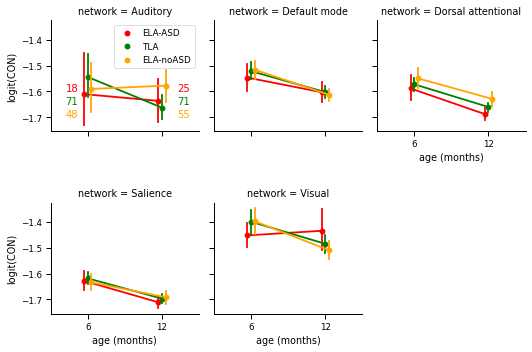

In [8]:
palette = sns.color_palette(["red", "green", "orange"])


tmp3 = tmp[tmp.site != "Combined"].groupby(["age", "subject", "sex", "site", "group", "network"], observed=True).mean()[["log_con"]].reset_index()
tmp3 = tmp3[tmp3.site != "Combined"]
tmp3 = tmp3[tmp3.sex != "M & F"]



tmp3.group = tmp3.group.astype(str)
tmp3.loc[tmp3.group == "Control", "group"] = "TLA"
tmp3.loc[tmp3.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp3.loc[tmp3.group == "HRA-noASD", "group"] = "ELA-noASD"


g = sns.catplot(data=tmp3,  col="network", kind="point", y="log_con",  col_wrap=3, legend_out=False, 
                height=2.5, aspect=1, **plot_kwds)

for ax in g.axes[[0, 3]]:
    ax.set_ylabel("logit(CON)")
    
for ax in g.axes[2:]:
    ax.set_xlabel("age (months)")
#for ax in g.axes[0]:
#    ax.set_xlabel("")

legend = g.axes[0].legend()


counts = tmp3.groupby(["network", "group", "age"]).count()["subject"]
for network, ax in zip(tmp3.network.unique(), g.axes): 
    for group, color, y in zip(group_order, color_order, [-1.6, -1.65, -1.7]):
        for age, x in zip([6, 12], [-0.3, 1.2]):
            ax.text(x, y, f"{counts[network, group, age]}",
                    color=color)
    break


g.fig.tight_layout(h_pad=4, w_pad=1)
g.fig.savefig("images/" + "network_relationships.png", dpi=300)

### Regional specificity
- logit-transformed
- Outlier rejected

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_30183/3919167008.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


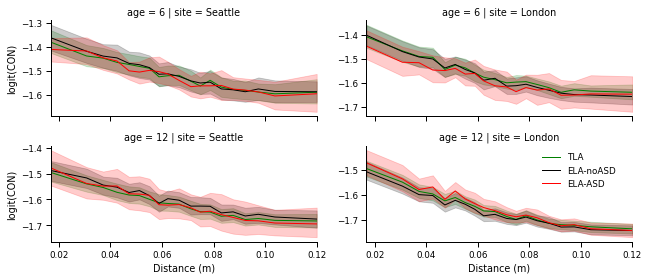

In [9]:
del dat["dist_bin"]
add_bin_dist(dat, "dist", 20)

tmp = dat[~dat.outliers_logit].groupby(["dist_bin", "subject", "site", "age", "group"], observed=True).mean().reset_index()
tmp["log_con"] = logit(tmp.con)

tmp.group = tmp.group.astype(str)
tmp.loc[tmp.group == "Control", "group"] = "TLA"
tmp.loc[tmp.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp.loc[tmp.group == "HRA-noASD", "group"] = "ELA-noASD"

g = sns.relplot(x="dist_bin", y="log_con", kind="line", hue="group", col="site", row="age",
                data=tmp, facet_kws={"sharex":True, "sharey":False},
                palette=sns.color_palette(["green", "black", "red"]), 
                hue_order=["TLA", "ELA-noASD", "ELA-ASD"], height=2, aspect=2)
for ax in g.axes.ravel():
    ax.set_xlim(np.min(tmp.dist_bin), np.max(tmp.dist_bin))

for ax in g.axes[-1]:
    ax.set_xlabel("Distance (m)")
for ax_row in g.axes:
    ax_row[0].set_ylabel("logit(CON)")

leg = g._legend
leg.set_title("")
leg.set_bbox_to_anchor([0.95, 0.38])    

plt.tight_layout()
plt.savefig("images/" + "line_plot_distance_effect_logit_outliers_rejected.png", dpi=300)

In [10]:
pos_df = acareeg.infantmodels.region_centers_of_masse(age=12, subjects_dir=".", include_vol_src=False)

tmp = dat[~dat.outliers_logit]
tmp = pd.concat([tmp, tmp.rename(columns={"region1" : "region2", "region2": "region1"})])
tmp["log_con"] = logit(tmp.con)
tmp = tmp.groupby(["region1", "subject", "site", "age", "group"], observed=True).mean().reset_index()

tmp.group = tmp.group.astype(str)
tmp.loc[tmp.group == "Control", "group"] = "TLA"
tmp.loc[tmp.group == "HRA-ASD", "group"] = "ELA-ASD"
tmp.loc[tmp.group == "HRA-noASD", "group"] = "ELA-noASD"

tmp = tmp.merge(pos_df[["region", "y"]], left_on="region1", right_on="region")

    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Loading surfaces...



Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/bem/ANTS12-0Months3T-5120-5120-5120-bem-sol.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


# Supplementary analyses looking a localized effects

In [11]:
from scipy.stats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

g2 = "TLA"
groupby = tmp.groupby(["region1", "site", "age"], observed=True)
vars = {}
for var in ["es", "ts", "ps", "n1", "n2", "power"]:
    vars[var] = {"ELA-noASD": [], "ELA-ASD": []}
for (region, site, age), group in groupby:
    for g1 in vars["es"]:
        vars["es"][g1].append(cohen_d(group[group.group == g1]["log_con"], 
                              group[group.group == g2]["log_con"]))
        t, p = ttest_ind(group[group.group == g1]["log_con"], 
                         group[group.group == g2]["log_con"])
        vars["ts"][g1].append(t)
        vars["ps"][g1].append(p)
        vars["n1"][g1].append(len(group[group.group == g1]["log_con"]))
        vars["n2"][g1].append(len(group[group.group == g2]["log_con"]))        
        vars["power"][g1].append(tt_ind_solve_power(effect_size=abs(vars["es"][g1][-1]), alpha=0.05, 
                                                    nobs1=vars["n1"][g1][-1], ratio=vars["n2"][g1][-1]/vars["n1"][g1][-1]))

In [12]:
tmp2 = groupby.mean()
tmp3 = groupby.mean()
for var in ["es", "ts", "ps", "n1", "n2", "power"]:
    tmp2[var] =  vars[var]["ELA-noASD"]
    tmp3[var] =  vars[var]["ELA-ASD"]
    
tmp2["contrast"] = "ELA-noASD - TLA"
tmp3["contrast"] = "ELA-ASD - TLA"

tmp2 = pd.concat([tmp2, tmp3]).reset_index()

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


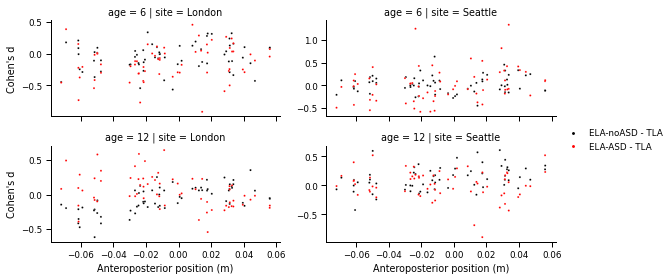

In [13]:
g = sns.relplot(x="y", y="es", kind="scatter", hue="contrast", 
                col="site", row="age",
                data=tmp2, facet_kws={"sharex":True, "sharey":False},
                palette=sns.color_palette(["black", "red"]), 
                hue_order=["ELA-noASD - TLA", "ELA-ASD - TLA"], 
                height=2, aspect=2)

for ax in g.axes[-1]:
    ax.set_xlabel("Anteroposterior position (m)")
for ax_row in g.axes:
    ax_row[0].set_ylabel("Cohen's d")

leg = g._legend
leg.set_title("")

In [14]:
pd.set_option("display.precision", 3)
x = tmp2.groupby(["region1", "age", "contrast"]).min()["es"].sort_values()
tmp3 = tmp2.pivot_table(index=["region1", "age", "contrast"], columns="site", 
                        values=["es", "ts", "ps", "n1", "n2", "power"])
tmp3 = tmp3.loc[x[x > 0.3].index].reorder_levels([1, 0], axis=1).sort_index(axis=1).reset_index()
tmp3.columns.names = ["", ""]
tmp3.rename(columns={"ps": "p", "ts": "t", "es": "d", "region1": 'region'})

region age       contrast London                               \
                                               d  n1  n2  power      p      t   
0  inferiorparietal-rh  12  ELA-ASD - TLA  0.578  15  41  0.469  0.061  1.916   

  Seattle                               
        d  n1  n2  power      p      t  
0   0.519  10  30  0.283  0.164  1.421

In [15]:
x = tmp2.groupby(["region1", "age", "contrast"]).max()["es"].sort_values()

tmp3 = tmp2.pivot_table(index=["region1", "age", "contrast"], columns="site", 
                        values=["es", "ts", "ps", "n1", "n2", "power"])
tmp3 = tmp3.loc[x[x < -0.3].index].reorder_levels([1, 0], axis=1).sort_index(axis=1).reset_index()   
tmp3.columns.names = ["", ""]
tmp3.rename(columns={"ps": "p", "ts": "t", "es": "d", "region1": 'region'})                    

region age         contrast London                 \
                                                        d  n1  n2  power   
0         lateraloccipital-lh   6    ELA-ASD - TLA -0.456  11  32  0.247   
1            pericalcarine-lh   6    ELA-ASD - TLA -0.732  11  32  0.534   
2            pericalcarine-rh  12  ELA-noASD - TLA -0.472  31  41  0.498   
3  caudalanteriorcingulate-lh   6    ELA-ASD - TLA -0.915  11  32  0.725   
4      caudalmiddlefrontal-lh  12    ELA-ASD - TLA -0.367  15  41  0.223   
5       transversetemporal-rh   6    ELA-ASD - TLA -0.322  11  32  0.147   
6         superiorparietal-rh   6    ELA-ASD - TLA -0.417  11  32  0.214   
7                 fusiform-rh   6    ELA-ASD - TLA -0.315  11  32  0.142   
8                 bankssts-rh   6    ELA-ASD - TLA -0.312  11  32  0.141   

                Seattle                               
       p      t       d  n1  n2  power      p      t  
0  0.199 -1.306  -0.492   7  39  0.216  0.238 -1.198  
1  0.043 -2.094  -0.430   7  39  0.176  0.301 -1.047  
2  0.051 -1.983  -0.426  24  30  0.332  0.126 -1.554  
3  0.012 -2.618  -0.374   7  39  0.145  0.368 -0.910  
4  0.229 -1.218  -0.687  10  30  0.450  0.068 -1.882  
5  0.362 -0.922  -0.558   7  39  0.265  0.181 -1.361  
6  0.240 -1.192  -0.319   7  39  0.118  0.441 -0.777  
7  0.373 -0.901  -0.350   7  39  0.133  0.399 -0.852  
8  0.377 -0.893  -0.512   7  39  0.230  0.219 -1.246